In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv


In [2]:
data = pd.read_csv('../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
data.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


# Introduction

This dataset is a KAGGLE provided dataset which contains text messages, and the goal is to try to try to classify these messages as spam or not based on the words. As part of this experiment, I'll try different unsupervised learning methods and compare and contrast them based on different factors to come up with a choice for the model with the best parameters, and then discuss my theories on why it is the best.

## EDA
Before proceeding onto understanding what the data is about, we should 1. investigate the data, 2. clean up the data. Before approaching any problem, its important to understand what the data is composed of. To do this, we'll use some graphs and visualizations to understand what exactly we are working with.

Category
ham     4825
spam     747
Name: count, dtype: int64


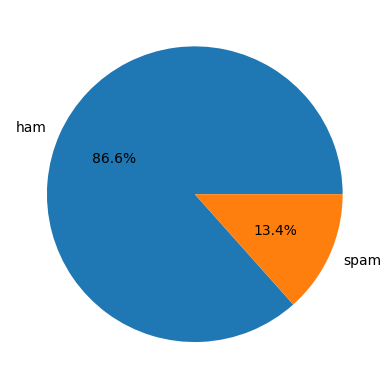

In [3]:
print(data['Category'].value_counts())
plt.pie(data['Category'].value_counts(), labels=data['Category'].unique().tolist(), autopct='%1.1f%%')
plt.show()

As shown by the pie graph, we can clearly see that there are a lot more of the 'ham' data points than 'spam', something we might want to consider when creating our model.

In [4]:
word_count = []
for index, row in data.iterrows():
    word_count.append(len(row['Message']))

print(sum(word_count)/len(word_count))

80.36898779612348


The average number of words is 80.36, but that isn't very helpful. We should take a better look at the distribution of the words itself.

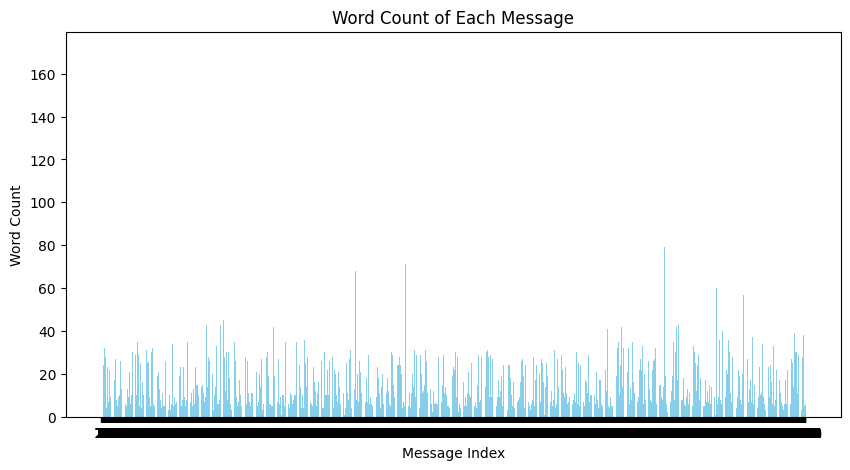

In [5]:
word_count = [len(row['Message'].split()) for index, row in data.iterrows()]

# Plotting the word count
plt.figure(figsize=(10, 5))
plt.bar(range(len(word_count)), word_count, color='skyblue')
plt.xlabel('Message Index')
plt.ylabel('Word Count')
plt.title('Word Count of Each Message')
plt.xticks(range(len(word_count)), range(len(word_count)))
plt.show()

now the actual cleaning of the data.

In [6]:

# Convert messages to lowercase
data['Message'] = data['Message'].str.lower()

# Remove punctuation
data['Message'] = data['Message'].str.translate(str.maketrans('', '', string.punctuation))

# Remove extra whitespace
data['Message'] = data['Message'].str.strip()
data['Message'] = data['Message'].str.replace(r'\s+', ' ', regex=True)


Now remove the stopwords

In [7]:
# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Apply the function to the 'Text' column
data['Message'] = data['Message'].apply(remove_stopwords)

Now, actually splitting the data. We have a lot of 'ham' compared to 'spam', so I'm going to downsample the 'ham', so training the model actually works. 

In [8]:
ham_df = data[data['Category'] == 'ham']
spam_df = data[data['Category'] == 'spam']

ham_df_downsampled = ham_df.sample(n=len(spam_df))

balanced_df = pd.concat([ham_df_downsampled, spam_df])

train_df, test_df = train_test_split(
    balanced_df,
    test_size=0.3, stratify=balanced_df['Category']
)

train_df.head()

,Category,Message
629,spam,new textbuddy chat 2 horny guys ur area 4 25p ...
5487,spam,2p per min call germany 08448350055 bt line 2p...
1468,ham,wont touch permission
1956,ham,aight ill grab something eat text youre back mu
3554,ham,din tell u jus 420


Now to actually train

In [22]:
results = []
best_accuracy = 0
best_params = {}

for min_df in range(1,10):
    for max_df in [0.3, 0.5, 0.7, 0.9, 1.0]:
        for norm in ['l1','l2']:
            print("starting")
            # Set up your vectorizer and NMF model with these parameters
            vectorizer = TfidfVectorizer(norm=norm, stop_words=None,min_df=min_df, max_df = max_df)
            matrix = vectorizer.fit_transform(train_df['Message'])

            nmf_model = NMF(n_components=len(train_df['Category'].unique()))
            document_topic_matrix = nmf_model.fit_transform(matrix)

            # Assign topics
            train_df['Assigned_Cat_Num'] = document_topic_matrix.argmax(axis=1) + 1

            # Map topics to categories (using the method from the previous response)
            topic_category_map = {}
            for topic_num in range(1, 3):
                topic_docs = train_df[train_df['Assigned_Cat_Num'] == topic_num]
                most_common_category = topic_docs['Category'].mode().iloc[0]
                topic_category_map[topic_num] = most_common_category

            # Assign categories based on the mapping
            train_df['Assigned_Category'] = train_df['Assigned_Cat_Num'].map(topic_category_map)

            # Calculate accuracy
            accuracy = (train_df['Category'] == train_df['Assigned_Category']).mean()

            results.append({
                'max_df': max_df,
                'min_df': min_df,
                'norm' : norm,
                'accuracy': accuracy
            })

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'max_df': max_df,
                    'min_df': min_df,
                    'norm' : norm
                }

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
Best parameters: {'max_df': 0.3, 'min_df': 6, 'norm': 'l1'}
Best accuracy: 0.6880382775119617


And now try this without the sampling....



In [24]:
results = []
best_accuracy = 0
best_params = {}

for min_df in range(1,10):
    for max_df in [0.3, 0.5, 0.7, 0.9, 1.0]:
        for norm in ['l1','l2']:
            vectorizer = TfidfVectorizer(norm=norm, stop_words=None,min_df=min_df, max_df = max_df)
            matrix = vectorizer.fit_transform(data['Message'])

            nmf_model = NMF(n_components=len(train_df['Category'].unique()))
            document_topic_matrix = nmf_model.fit_transform(matrix)

            data['Assigned_Cat_Num'] = document_topic_matrix.argmax(axis=1) + 1

            topic_category_map = {}
            for topic_num in range(1, 3):
                topic_docs = data[data['Assigned_Cat_Num'] == topic_num]
                most_common_category = topic_docs['Category'].mode().iloc[0]
                topic_category_map[topic_num] = most_common_category

            data['Assigned_Category'] = data['Assigned_Cat_Num'].map(topic_category_map)

            accuracy = (data['Category'] == data['Assigned_Category']).mean()

            results.append({
                'max_df': max_df,
                'min_df': min_df,
                'norm' : norm,
                'accuracy': accuracy
            })

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'max_df': max_df,
                    'min_df': min_df,
                    'norm' : norm
                }

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Best parameters: {'max_df': 0.3, 'min_df': 1, 'norm': 'l1'}
Best accuracy: 0.8659368269921034


So we see, the actual better accuracy comes from the non-downsampled data, possibly because if we were to downsample, the data representation no longer mimics reality, i.e the world is not 50/50 spam, but more follows the data above. Now, trying a few optimizations.

In [26]:
results = []
best_accuracy = 0
best_params = {}

for min_df in range(1,10):
    for max_df in [0.3, 0.5, 0.7, 0.9, 1.0]:
        for norm in ['l1','l2']:
            for ratio in [0.0, 0.1, 0.5, 1.0]:
                vectorizer = TfidfVectorizer(norm=norm,ngram_range=(1, 2),sublinear_tf=True, stop_words=None,min_df=min_df, max_df = max_df)
                matrix = vectorizer.fit_transform(data['Message'])

                nmf_model = NMF(n_components=2, l1_ratio = ratio)
                document_topic_matrix = nmf_model.fit_transform(matrix)

                data['Assigned_Cat_Num'] = document_topic_matrix.argmax(axis=1) + 1
                topic_category_map = {}
                for topic_num in range(1, 2):
                    topic_docs = data[data['Assigned_Cat_Num'] == topic_num]
                    most_common_category = topic_docs['Category'].mode().iloc[0]
                    topic_category_map[topic_num] = most_common_category

                data['Assigned_Category'] = data['Assigned_Cat_Num'].map(topic_category_map)

                accuracy = (data['Category'] == data['Assigned_Category']).mean()

                results.append({
                    'max_df': max_df,
                    'min_df': min_df,
                    'norm' : norm,
                    'accuracy': accuracy
                })

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'max_df': max_df,
                        'min_df': min_df,
                        'norm' : norm
                    }

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Best parameters: {'max_df': 0.3, 'min_df': 1, 'norm': 'l1'}
Best accuracy: 0.8187365398420675


## Different Model

Looks like even with certain optimizations, it does not help the model performance. Let's try using unsupervised learning with TruncatedSVD

In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

results = []
best_accuracy = 0
best_params = {}

for min_df in range(1, 10):
    for max_df in [0.3, 0.5, 0.7, 0.9, 1.0]:
        for norm in ['l1', 'l2']:
            for ratio in [0.0, 0.1, 0.5, 1.0]:
                # Set up your vectorizer with these parameters
                vectorizer = TfidfVectorizer(
                    norm=norm,
                    ngram_range=(1, 2),
                    sublinear_tf=True,
                    stop_words=None,
                    min_df=min_df,
                    max_df=max_df
                )
                matrix = vectorizer.fit_transform(data['Message'])

                svd_model = TruncatedSVD(n_components=2)
                document_topic_matrix = svd_model.fit_transform(matrix)

                data['Assigned_Cat_Num'] = document_topic_matrix.argmax(axis=1) + 1

                topic_category_map = {}
                for topic_num in range(1, 3):
                    topic_docs = data[data['Assigned_Cat_Num'] == topic_num]
                    most_common_category = topic_docs['Category'].mode().iloc[0]
                    topic_category_map[topic_num] = most_common_category

                data['Assigned_Category'] = data['Assigned_Cat_Num'].map(topic_category_map)

                # Calculate accuracy
                accuracy = (data['Category'] == data['Assigned_Category']).mean()

                results.append({
                    'max_df': max_df,
                    'min_df': min_df,
                    'norm': norm,
                    'accuracy': accuracy
                })

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'max_df': max_df,
                        'min_df': min_df,
                        'norm': norm
                    }

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)


Best parameters: {'max_df': 0.3, 'min_df': 1, 'norm': 'l1'}
Best accuracy: 0.8659368269921034


In [13]:

new_data = ["Hey, are you coming to the party tonight?"]

new_matrix = vectorizer.transform(new_data)

new_document_topic_matrix = nmf_model.transform(new_matrix)

new_assigned_cat_nums = new_document_topic_matrix.argmax(axis=1) + 1

new_assigned_categories = [topic_category_map[topic_num] for topic_num in new_assigned_cat_nums]

for i, msg in enumerate(new_data):
    print(f"Message: {msg}")
    print(f"Predicted Category: {new_assigned_categories[i]}\n")


Message: Hey, are you coming to the party tonight?
Predicted Category: ham



## Next steps:

Hook it up with flask and serve it as an api endpoint, and maybe connect to my texts so i can classify spam and compare it with the IOS comparison of my text messages and see if any are misclassified in my model. I feel like that would be fun since it's using real life data on something that is helpful to me to make my life easier.

## Discussion / Conclusion

The optimizations given to NMF did not help, and the best accuracy is 86%, which is good, but could be better. I think it hovered there because the dataset was so overwhelmingly skewed. The difference between the two SVDs didn't really help either. Overall, this is an interesting problem to work on!